<a href="https://www.kaggle.com/code/aurelegermain/svm-classification-with-opencv-bonus-knn?scriptVersionId=165841453" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split

# Features example

We hare going to use the hog features from skimage. </br>
We take a sample image to illustrate it.

In [2]:
test_file = '/kaggle/input/neural-networks-homer-and-bart-classification/homer_bart_1/bart110.bmp'

test_image = cv2.imread(test_file) #We load the image

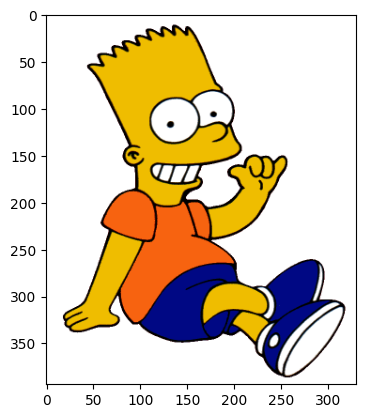

In [3]:
plt.imshow(test_image[...,::-1]) #OpenCV use the BGR format and matplotlib use RGB so we convert BGR to RGB

In [4]:
test_image = cv2.resize(test_image, (128, 128)) #we resize the image
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY) #we convert it to 1 channel 

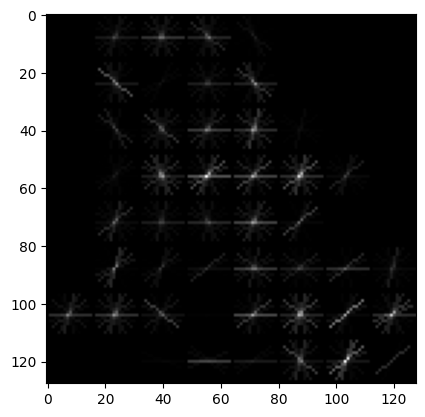

In [5]:
from skimage.feature import hog

test_image_features, test_hog_image = hog(test_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

## This is what the hog feature looks like
plt.imshow(test_hog_image, cmap=plt.cm.gray)

# Dataset

In [6]:
import os

image_folder = '/kaggle/input/neural-networks-homer-and-bart-classification/homer_bart_1'
filenames = os.listdir(image_folder) #list of all the bmp images without folder
filenames.sort()
filenames[:10]

['bart1.bmp',
 'bart10.bmp',
 'bart100.bmp',
 'bart101.bmp',
 'bart102.bmp',
 'bart103.bmp',
 'bart104.bmp',
 'bart105.bmp',
 'bart106.bmp',
 'bart108.bmp']

In [7]:
labels = np.array([int('bart' in filename) for filename in filenames]) #the labels, 1 for bart and 0 for homer
labels.reshape((len(labels),1))
labels[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [8]:
#just to check if everything file has either "bart" or "homer" in its name
(sum((int('bart' in filename) for filename in filenames)) + sum((int('homer' in filename) for filename in filenames))) == len(filenames) 

True

In [9]:
labels_dic = {'Homer': 0, 'Bart': 1}
labels_dic

{'Homer': 0, 'Bart': 1}

In [10]:
number_images = {'Names': ['Homer', 'Bart'], 'Number': [len(labels) - np.sum(labels), np.sum(labels)]}
number_images

{'Names': ['Homer', 'Bart'], 'Number': [109, 160]}

<Axes: >

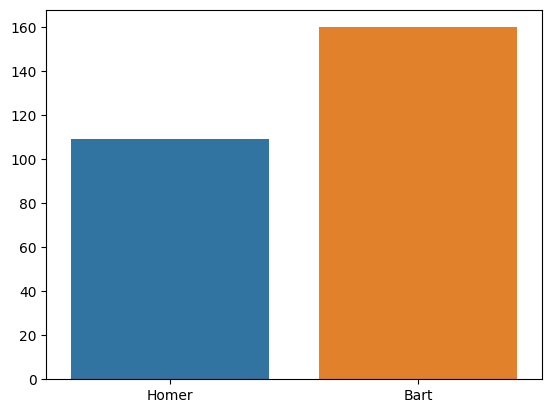

In [11]:
sns.barplot(number_images, x='Names', y='Number')

We split the datasets into train and test sets.

In [12]:
filenames_train, filenames_test, y_train, y_test = train_test_split(filenames, labels, test_size = 0.2, random_state = 4)

In [13]:
#this will load the images into a list.
def load_data(list_images):
    df_images = []
    for image in list_images:
        image = os.path.join(image_folder, image) #we join the folder and image name to obtain the image path
        image = cv2.imread(image) #we read the image
        image = cv2.resize(image, (128, 128)) #we resize it
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #we convert it to 1 channel (Gray scale)
        
        df_images.append(image) #we append the image to the list
    return df_images

In [14]:
images_train = load_data(filenames_train)
images_test = load_data(filenames_test)
images_train[0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [15]:
#This will compute the hog feature and append it to a list
def hog_feature(df_images):
    df_hogs = []
    for image in df_images:
        hog_features, hog_image = hog(image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))
        df_hogs.append(hog_features)
    return df_hogs

In [16]:
hogs_train = hog_feature(images_train)
hogs_test = hog_feature(images_test)
hogs_train[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [17]:
hogs_train = np.array(hogs_train).astype(np.float32)
hogs_test = np.array(hogs_test).astype(np.float32)

# Model

We create the SVM model.

In [18]:
svm = cv2.ml.SVM_create()
#svm.setType(cv2.ml.SVM_C_SVC)
#svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6))

In [19]:
svm.trainAuto(hogs_train, cv2.ml.ROW_SAMPLE, y_train)

True

# Accuracy

In [20]:
y_pred = svm.predict(hogs_test)

In [21]:
from sklearn.metrics import accuracy_score
accuracy_SVM = accuracy_score(y_test, y_pred[1])
accuracy_SVM

0.8148148148148148

# Confusion Matrix

In [22]:
from sklearn.metrics import confusion_matrix
cmx = confusion_matrix(y_test, y_pred[1], labels=list(labels_dic.values()))

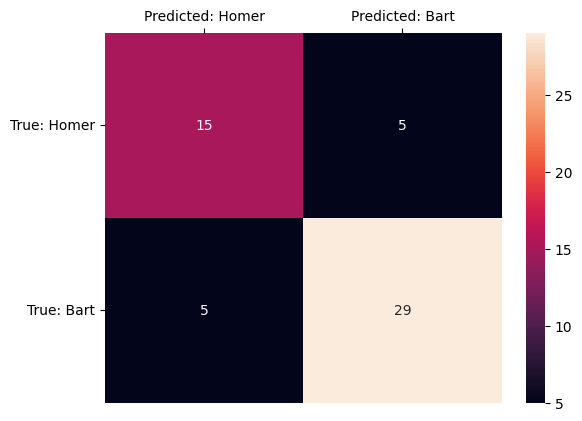

In [23]:
cmx_df = pd.DataFrame(cmx)
ax = sns.heatmap(cmx_df, annot=True)
ax.set_xticklabels(['Predicted: Homer', 'Predicted: Bart'])
ax.set_yticklabels(['True: Homer', 'True: Bart'])
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top()

In [24]:
#a little function what will come in handy during this notebook
def show_cmx(y_pred):
    if type(y_pred) is tuple: y_pred = y_pred[1]
    cmx = confusion_matrix(y_test, y_pred, labels=list(labels_dic.values()))
    cmx_df = pd.DataFrame(cmx)
    ax = sns.heatmap(cmx_df, annot=True)
    ax.set_xticklabels(['Predicted: Homer', 'Predicted: Bart'])
    ax.set_yticklabels(['True: Homer', 'True: Bart'])
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.xaxis.tick_top()

# F1 score

In [25]:
from sklearn.metrics import f1_score
f1_scr = f1_score(y_test, y_pred[1])
f1_scr

0.8529411764705882

# Misclassified examples

In [26]:
list_misclassified = [i for i in range(len(y_test)) if y_test[i] != y_pred[1][i]]
list_misclassified

[0, 1, 7, 12, 16, 17, 18, 33, 36, 44]

In [27]:
def show_misclassified(list_misclassified):
    for idx in list_misclassified:      
        image = os.path.join(image_folder, filenames_test[idx]) #we join the folder and image name to obtain the image path
        image = cv2.imread(image) #we read the image
        #image = cv2.resize(image, (128, 128)) #we resize it
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #we convert it to RGB as cv2 use the BGR format
        plt.imshow(image)
        plt.show()

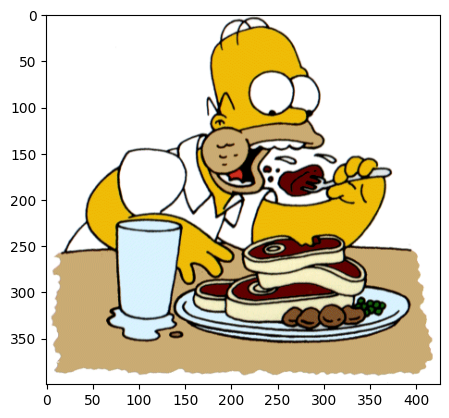

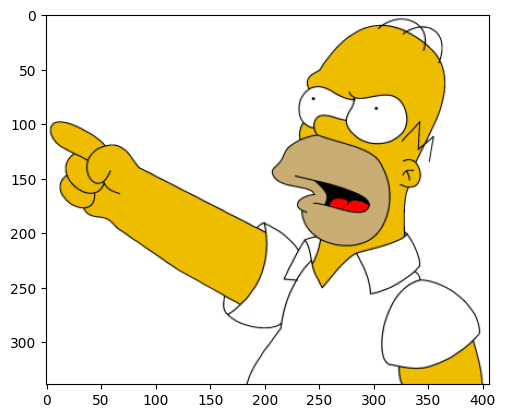

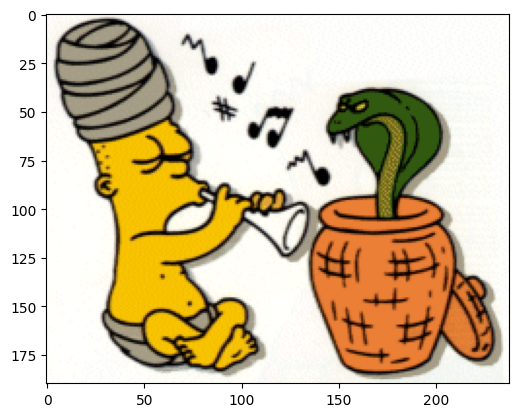

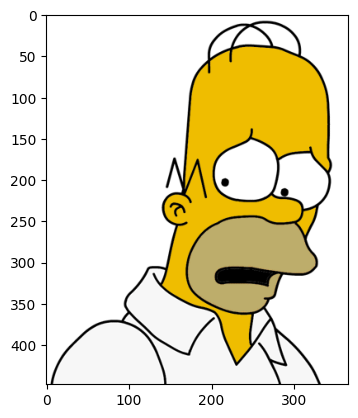

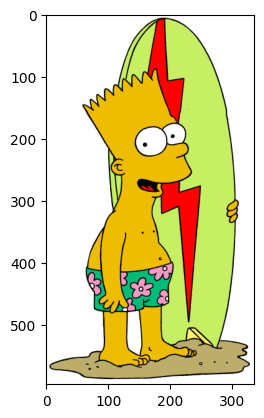

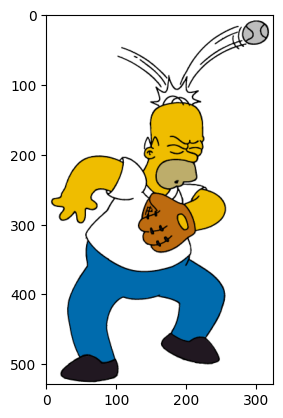

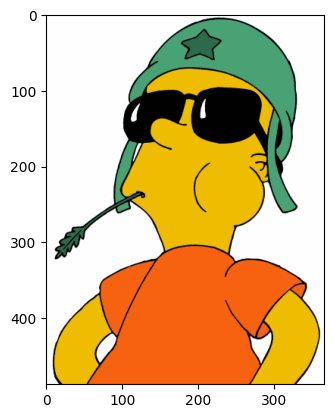

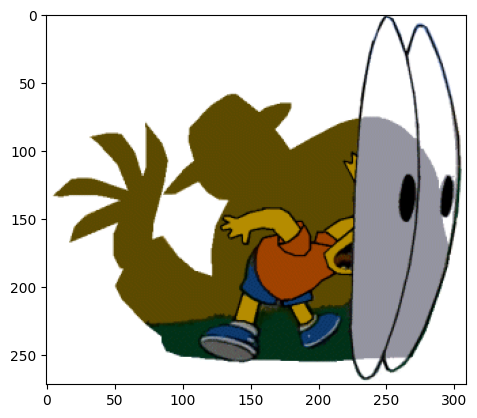

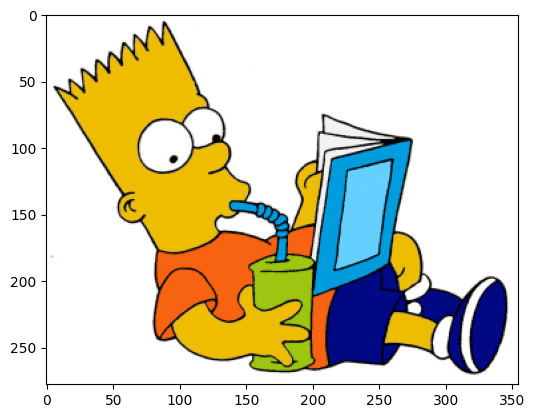

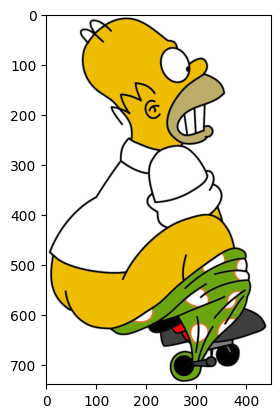

In [28]:
show_misclassified(list_misclassified)

# SVM with only pixels value

What would happen if we only used the grayscale images as feature instead of the hog ?

In [29]:
images_train = np.array(images_train).astype(np.float32)
images_test = np.array(images_test).astype(np.float32)

As an image is a 2 dimensional array we need to flatten each images into a 1 dimensional array.

In [30]:
images_train_flat = images_train.reshape(len(images_train), -1)
images_test_flat = images_test.reshape(len(images_test), -1)

We create the second svm model.

In [31]:
svm_pixels = cv2.ml.SVM_create()
#svm.setType(cv2.ml.SVM_C_SVC)
#svm.setKernel(cv2.ml.SVM_LINEAR)
svm_pixels.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6))

In [32]:
svm_pixels.trainAuto(images_train_flat, cv2.ml.ROW_SAMPLE, y_train)

True

In [33]:
y_pred_flat = svm_pixels.predict(images_test_flat)

We compute the accuracy.

In [34]:
accuracy_flat_SVM = accuracy_score(y_test, y_pred_flat[1])
accuracy_flat_SVM

0.6296296296296297

In [35]:
len(y_pred)

2

We plot the confusion matrix

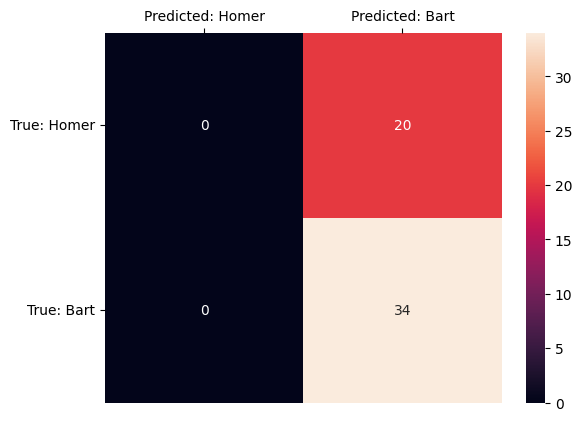

In [36]:
show_cmx(y_pred_flat)

Looking at the confucsion matrix, it seems that the model just classified everything as "Bart".

# KNN classification

**With flatten images**

We initialize the KNN and train it on the flat train dataset.

In [37]:
knn = cv2.ml.KNearest_create()
knn.train(images_train_flat, cv2.ml.ROW_SAMPLE, y_train)

True

We want to find the best value of k (the number of neighbours to take into account).

In [38]:
k_list =  [i + 1 for i in range(10)]
k_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [39]:
k_results = []

for k in k_list:
    _,result,_,_ = knn.findNearest(images_test_flat,k=k)
    result = result.reshape(len(result))
    accuracy = sum((result == y_test)*1)/len(result)
    k_results.append(accuracy)

In [40]:
k_results_dic = {'K': k_list, 'Accuracy': k_results}

<Axes: xlabel='K', ylabel='Accuracy'>

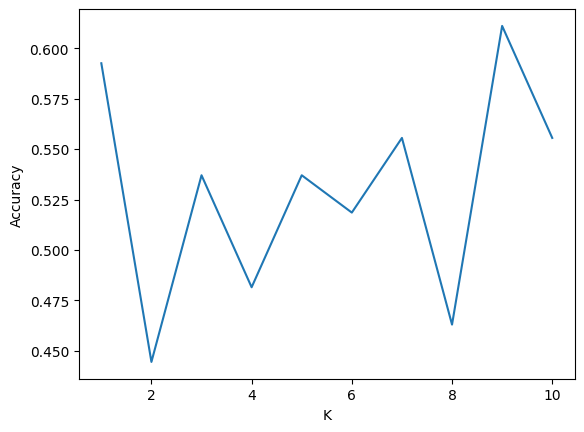

In [41]:
sns.lineplot(data=k_results_dic, x="K", y="Accuracy")

Clearly the classification of the flatten images using KNN is not going anywhere but I'm still going to discuss the results seriously.


The two bests values of K are 1 and 9. 

In [42]:
ret,y_pred_flat_knn,neighbours,dist = knn.findNearest(images_test_flat,k=9)

In [43]:
accuracy_flat_KNN = accuracy_score(y_test, y_pred_flat_knn)
accuracy_flat_KNN

0.6111111111111112

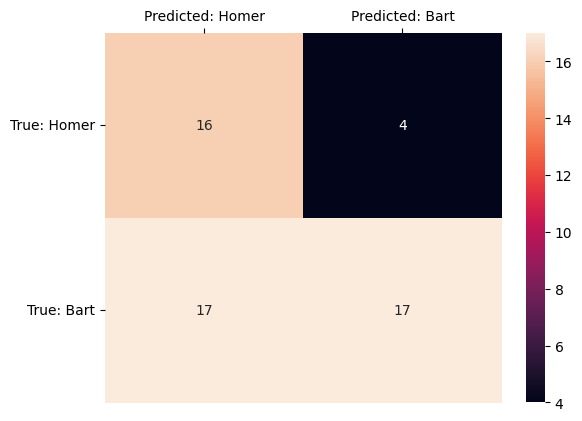

In [44]:
show_cmx(y_pred_flat_knn)

**With HOG**

In [45]:
knn_hog = cv2.ml.KNearest_create()
knn_hog.train(hogs_train, cv2.ml.ROW_SAMPLE, y_train)

True

In [46]:
k_results_hog = []

for k in k_list:
    _,result,_,_ = knn_hog.findNearest(hogs_test,k=k)
    result = result.reshape(len(result))
    accuracy = sum((result == y_test)*1)/len(result)
    k_results_hog.append(accuracy)

In [47]:
k_results_hog_dic = {'K': k_list, 'Accuracy': k_results_hog}

<Axes: xlabel='K', ylabel='Accuracy'>

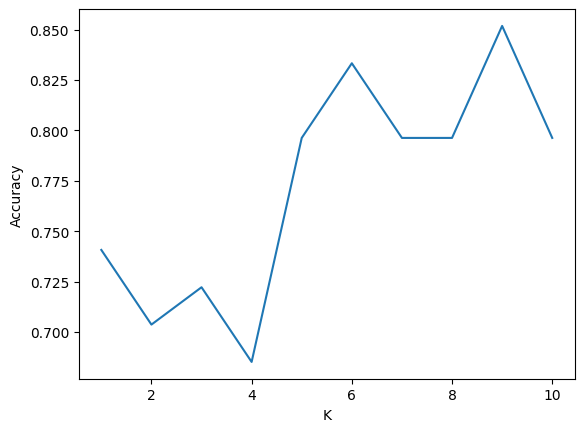

In [48]:
sns.lineplot(data=k_results_hog_dic, x="K", y="Accuracy")

In [49]:
ret,y_pred_hog_knn,neighbours,dist = knn_hog.findNearest(hogs_test,k=9)

In [50]:
accuracy_KNN = accuracy_score(y_test, y_pred_hog_knn)
accuracy_KNN

0.8518518518518519

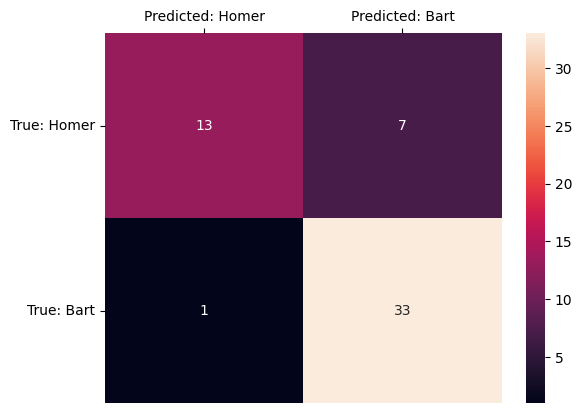

In [51]:
show_cmx(y_pred_hog_knn)

In [52]:
list_misclassified_knn = [i for i in range(len(y_test)) if y_test[i] != y_pred_hog_knn[i]]
list_misclassified_knn

[0, 1, 12, 14, 16, 17, 20, 46]

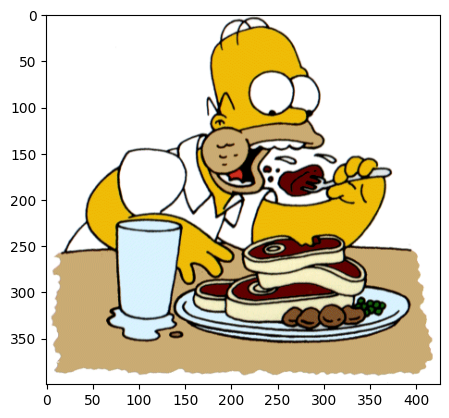

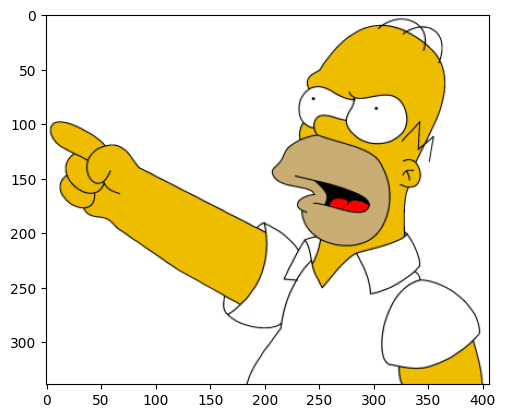

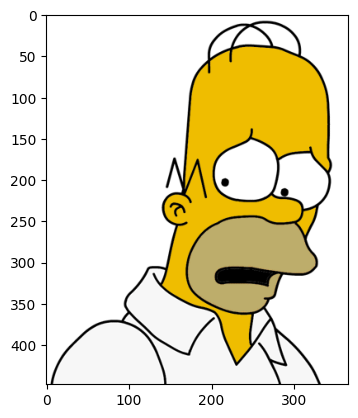

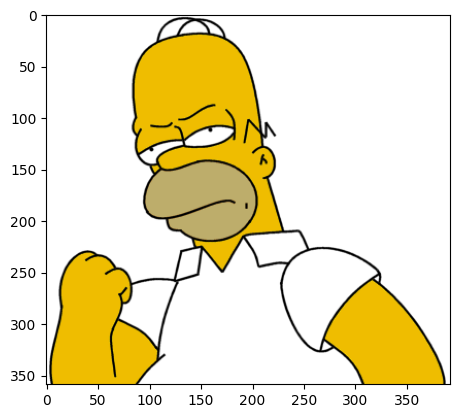

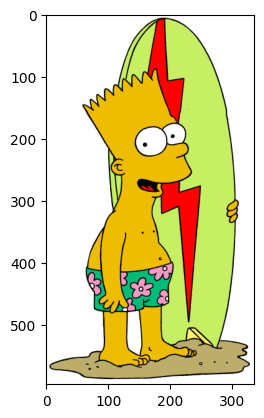

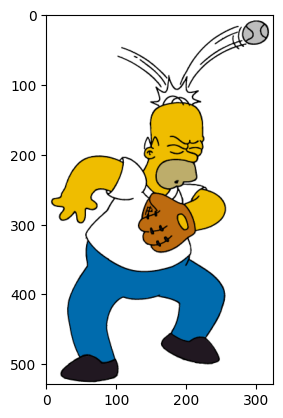

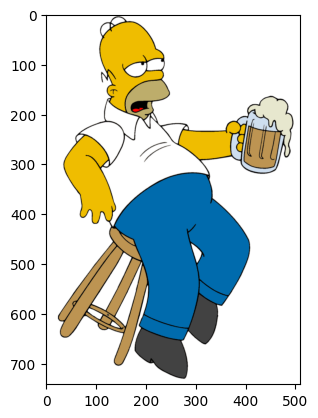

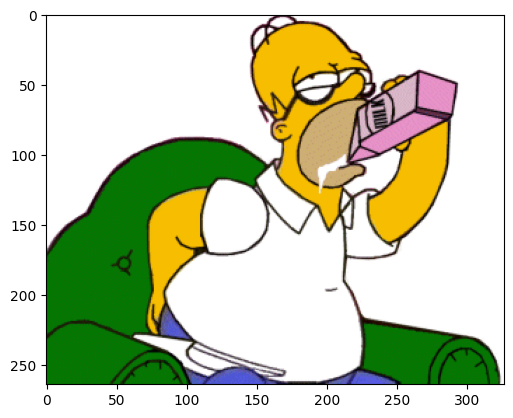

In [53]:
show_misclassified(list_misclassified_knn)

In [54]:
inter_list = list(set(list_misclassified_knn) & set(list_misclassified))
inter_list.sort()
inter_list

[0, 1, 12, 16, 17]

In [55]:
complement_list = list(set(list_misclassified_knn) ^ set(list_misclassified))
complement_list.sort()
complement_list

[7, 14, 18, 20, 33, 36, 44, 46]

The intersection between the misclassified images of SVM and KNN with HOG features.

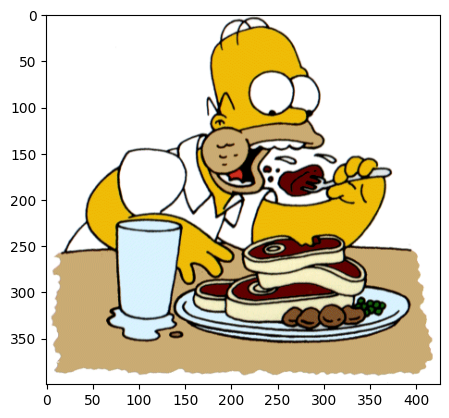

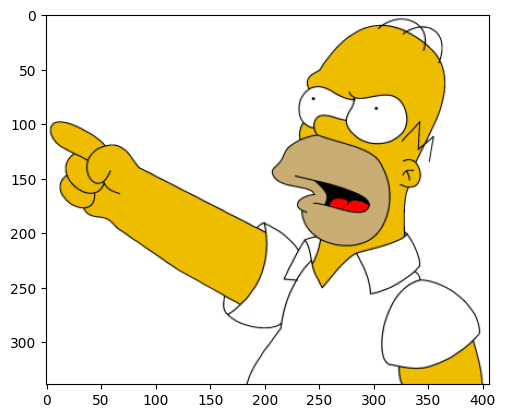

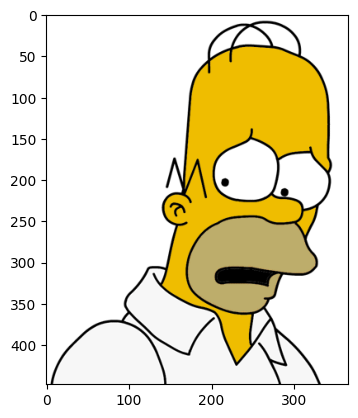

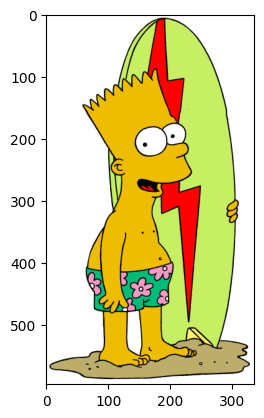

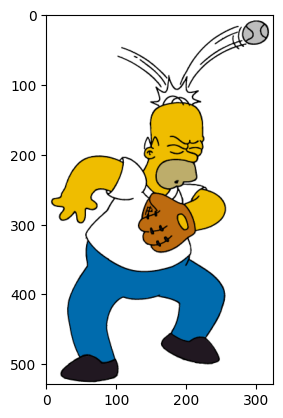

In [56]:
show_misclassified(inter_list)

In [57]:
results_dic = {'HOG': {'SVM': accuracy_SVM, 'KNN': accuracy_KNN }, 'Flat': {'SVM': accuracy_flat_SVM, 'KNN': accuracy_flat_KNN}}
results_dic = pd.DataFrame(results_dic)
results_dic

,HOG,Flat
SVM,0.814815,0.629630
KNN,0.851852,0.611111


# Conclusion for now

It's clearly better to use the HOG features instead of the flattened images. </br>
For the HOG features, KNN with 9 neighbours worked better than SVM. It has a better accuracy and misclassifed 8 images of the test set instead of 10 for SVM. </br>
Of course we can't draw a diffinitive conclusion.

# Flattened images

I will try to continue the classification with only flattened images, but after more preprocesing of the images (mainly a pixel value threshold I think).